<a href="https://colab.research.google.com/github/esnue/ThesisAllocationSystem/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Model**

# Introduction

This code script details the steps taken to develop a Transformers- and Pre-Trained based Language multi-label Text-Classification Model. 

The goal of the model is the ability to match students based on their thesis proposals to supervisors based on the content of their academic papers.

Using academic papers as train data is an approach that was proposed by the similarly-working [Toronto Matching System](https://www.cs.toronto.edu/~zemel/documents/tpms.pdf). Instead of matching students to professors, the Toronto Matching Systems assigns Peer-Reviewers based on their academic papers to submitted papers.

While thesis proposals tend to be coherent in their structure, academic papers usually have very differing structures, depending on the layout that the publisher demands. Constraining ourselves to few or one particular Journal outlet could have made the cleaning process and possibly the model training easier but would also have considerably reduced the size of the train data. 

Our multi-label text-classification method is based on Transformers and Pre-Trained Language Models. The Pre-Trained Mode is state-of-art [DistilBert](https://arxiv.org/abs/1910.01108). The Transformers version is [4.4.2](https://huggingface.co/transformers/).

We are finetuning a pretrained DistilBERT model for multilabel text classification. This is a very common application of text classification, where a given document can be classified into one or more categories. This approach best mirrors our use case where a thesis proposal could likely be allocated to more than one research area, given the interdisciplinary nature and overlap of research areas between chairs.

Before you attempt to run the script, make sure to secure the required modules and [datasets](https://drive.google.com/drive/folders/1ExS7M2OOkbYS5Z5O9pbPbaCpSa0rhGet?usp=sharing).

## **Requirements**

In [1]:
! pip install transformers==3.0.2

     |████████████████████████████████| 778kB 13.3MB/s 
     |████████████████████████████████| 1.2MB 29.3MB/s 
     |████████████████████████████████| 890kB 54.7MB/s 
     |████████████████████████████████| 3.0MB 53.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=082c59faeaae1d55ca57e04f5ec6929eb161d8e623f0c474fd31945c3e56fb32
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=bf0e19bae025c50f1e4c11e82611ef31aa67e686ff9e33790d30c2d5f43e0d04
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz


In [3]:
# Import requirements
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

from torchviz import make_dot

In [5]:
# Setting up the device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'gpu'

<a id='section02'></a>
### Importing and Pre-Processing the domain data

The required data set to run this script is `train-papers-label.csv`. It can be downloaded [here](https://drive.google.com/file/d/1-12x2qro_m9HqWUEwZU_l4njMJ6y1LoX/view?usp=sharing). Please make sure you've stored it on your GDrive or on your computer.

The section of the script implements the following tasks:

* Load the dataset `train-papers-label.csv`
* Tokenize the dataset
* Transform the dataset into a DataLoader

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Make sure that list items are correctly stored and read as integers, not as strings, which can happen while saving a data frame as csv. 

In [7]:
def check_form(data):
    cols = ['content', 'labels']
    if list(data.columns.values) == cols and (len(data['labels'].iloc[1])) == 28 and type(data['labels'].iloc[1]) == list and type(data['labels'].iloc[1][1]) == int : 
        print('Data is in correct form.')
        print(data.sample(5))
    elif list(data.columns.values) != cols:
        print('This data is not in correct form. It has to have two columns. One content column with strings, one labels column with lists of int.')
    elif (len(data['labels'].iloc[1])) != 28:
        print('This data is not in correct form. There must be 28 unique labels.')
    elif type(data['labels'].iloc[1]) != list:
        print('The labels must be stored in lists.')
    elif type(data['labels'].iloc[1][1]) != int: 
        print('The units in the list must be int.')
    else: 
        print('Something else is fishy.')

In [ ]:
# Data: Academic papers of professors as training data 
# Load df
train_df = pd.read_csv('/content/drive/MyDrive/ThesisAllocationSystem/data_final/train-papers-label.csv', converters={'labels': eval})

# Check form
check_form(train_df)

In [9]:
# Data: Thesis proposals by students as testing data 
# Load df
test_df = pd.read_csv('/content/drive/MyDrive/ThesisAllocationSystem/data_final/test-proposals-label.csv', converters={'labels': eval})

# Check form
check_form(test_df)

Data is in correct form.
                                             content                                             labels
5  b'New Thesis Proposal Form \n\nAY 2020-2021 \n...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...
2  b'Master_Thesis_Proposal\n\n\nMaster Thesis Pr...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
4  b'Thesis Proposal \n\nCitizen Perceptions and ...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
0  b'Anabel Berj\xf3n S\xe1nchez \n\n \n\nPROPOSA...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1  b'Master_Thesis_Proposal\n\n\nMaster Thesis Pr...  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...


In [27]:
# Data: Thesis proposals of professors embedded with BerTopic output as training data 
# Load df 
train_bert = pd.read_csv('/content/drive/MyDrive/ThesisAllocationSystem/data_final/ctm_label/train-label.csv', converters = {'labels': eval})

print(train_bert.iloc[0])
print(train_df.iloc[0])

prof                                        Hammerschmid2.txt
topic_id                                                   19
topic       ['public', 'management', 'state', 'policy', 's...
Name: 0, dtype: object
content    b'1 \n \n\nCurry, D., Hammerschmid, G., Jilke,...
labels     [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: 0, dtype: object


<a id='section03'></a>
### Preparing the Dataset and Dataloader

First, we define some key variables used for training/fine tuning later on. Centrally definiting key variables will make it easier later on to adjust and test metrics for different network configurations.

Next, we create a Tokenizer class alongside a DataLoader specifying how the text is pre-processed prior to sending it to the neural network and the number of batches to be sent to the neural network for training.

Tokenizer and Dataloader are constructs of the PyTorch library for defining and controlling the data pre-processing and its passage to neural network. For further reading into Dataset and Dataloader read the [docs at PyTorch](https://pytorch.org/docs/stable/data.html)

#### *Tokenizer* Dataset Class
- This class is defined to accept the `tokenizer`, `dataframe` and `max_length` as input and generate tokenized output and tags to be used by the DistilBERT model for training. 
- We are using the DistilBERT tokenizer to tokenize the data in the `text` column of the dataframe.
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`, `token_type_ids`

#### Dataloader
- Dataloader is used for creating training and validation dataloader sets that enable loading data to the neural network in the defined manner. This is required due to memory constraints.  
- Via `batch_size` and `max_len`, the DataLoader controls the amount of data loaded to the memory and passed to the neural network per turn. 
- Training and Validation dataloaders are used in the training and validation part of the flow respectively.

In [ ]:
# Configurations

# Defining key var
MAX_LEN = 500
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
EPOCHS = 3
LEARNING_RATE = 1e-05

# Import DistilBert Tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

In [ ]:
class Tokenizer(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.content
        self.targets = self.data.labels
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
# Creating the train dataset and dataloader for the neural network
train_data = train_df.sample(frac = 1,random_state = 200)
test_data = test_df.sample(frac = 1, random_state = 200)
# test_data = train_df.drop(train_data.index).reset_index(drop=True)
# train_data = train_data.reset_index(drop=True)

print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = Tokenizer(train_data, tokenizer, MAX_LEN)
testing_set = Tokenizer(test_data, tokenizer, MAX_LEN)

TRAIN Dataset: (811, 2)
TEST Dataset: (6, 2)


In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
# next(iter(training_loader))
# next(iter(testing_loader))

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `DistilBERTClass`. 
 - This network will have the `DistilBERT` model.  Follwed by a `Droput` and `Linear Layer`. They are added for the purpose of **Regularization** and **Classification** respectively. 
 - In the forward loop, there are 2 output from the `DistilBERTClass` layer.
 - The second output `output_1` or called the `pooled output` is passed to the `Drop Out layer` and the subsequent output is given to the `Linear layer`. 
 - Keep note the number of dimensions for `Linear Layer` is **28** because that is the total number of categories in which we are looking to classify our model
 - The data will be fed to the `DistilBERTClass` as defined in the dataset. 
 - Final layer outputs is what will be used to calcuate the loss and to determine the accuracy of models prediction. 
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference. 
 
#### Loss Function and Optimizer
 - The Loss is defined in the next cell as `loss_fn`.
 - As defined above, the loss function used will be a combination of Binary Cross Entropy which is implemented as [BCELogits Loss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss) in PyTorch
 - `Optimizer` is defined in the next cell.
 - `Optimizer` is used to update the weights of the neural network to improve its performance.

In [ ]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistilBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 256)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(256, 28)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

model = DistilBERTClass()
model.to(device)

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in_featu

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train(epoch):
    model.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%5000==0:
            print(f'Epoch: {epoch}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

1it [00:00,  1.14it/s]

Epoch: 0, Loss:  0.6841617226600647


203it [03:12,  1.06it/s]
1it [00:00,  1.10it/s]

Epoch: 1, Loss:  0.6847456693649292


203it [03:12,  1.06it/s]
1it [00:00,  1.07it/s]

Epoch: 2, Loss:  0.6792545914649963


203it [03:12,  1.06it/s]


As we can see, the loss rates convert but are still pretty high. This is something we will need to work on during the next weeks. 

<a id='section06'></a>
### Validating the Model

During the validation stage we pass the unseen data(Testing Dataset) to the model. This step determines how good the model performs on the unseen data. 

This unseen data are the student thesis proposals, `test-proposal-label.csv`
During the validation stage the weights of the model are not updated. Only the final output is compared to the actual value. This comparison is then used to calcuate the accuracy of the model. 

As defined above to get a measure of our models performance we are using the following metrics. 
- Hamming Score
- Hamming Loss

In [ ]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
def validation(testing_loader):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    with torch.no_grad():
        for _, data in tqdm(enumerate(testing_loader, 0)):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation(testing_loader)

final_outputs = np.array(outputs) >=0.5

2it [00:00,  7.12it/s]


In [ ]:
val_hamming_loss = metrics.hamming_loss(targets, final_outputs)
val_hamming_score = hamming_score(np.array(targets), np.array(final_outputs))

print(f"Hamming Score = {val_hamming_score}")
print(f"Hamming Loss = {val_hamming_loss}")

Hamming Score = 0.06060606060606061
Hamming Loss = 0.375


In [ ]:
import sklearn

y_true = targets
y_pred = final_outputs
cm = sklearn.metrics.multilabel_confusion_matrix(y_true, y_pred)

TypeError: ignored

TypeError: ignored

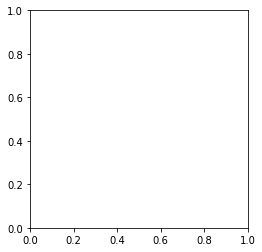

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()

    width, height = cm.shape

    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cm[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#later insert profs for number (alphabetically)
plot_confusion_matrix(cm, ['A', 'B', 'C'])
                      
                      
                      #['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
                           #'21', '22', '23', '24', '25', '26', '27', '28'])

Hamming Loss: 3 % incorrectly predicted labels.

<a id='section07'></a>
### Saving the trained model for inference

This is the final step in the process of fine tuning the model. 

The model and its vocabulary are saved locally. These files are then used to make inferences on new inputs of student research proposals.

BA LINH: Ich weiß nicht wie man das Vocab speichert

In [ ]:
# Saving the files for inference

#output_model_file = 'pytorch_distilbert_papers.bin'
#output_vocab_file = 'vocab_distilbert_papers.bin'

path = F"/content/drive/MyDrive/ThesisAllocationSystem/models/pytorch_distilbert_papers_3.bin" 
torch.save(model.state_dict(), path)

#path2 = F"/content/drive/MyDrive/ThesisAllocationSystem/models/pytorch_distilbert_papers.bin" 
#tokenizer.save_vocabulary(output_vocab_file.state_dict(), path)

#torch.save(model, output_model_file)
#tokenizer.save_vocabulary(output_vocab_file)

print('Saved')